In [7]:
import os
import numpy as np
import pyvista as pv
import nibabel
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score
import pandas as pd

from pathlib import Path

import numpy as np
import pyvista as pv
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

import polpo.preprocessing.pd as ppd
from polpo.models import ObjectRegressor
from polpo.preprocessing import (
    IndexMap,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.dict import DictMap, DictMerger
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalCsvDataLoader,
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.conversion import ToVertices
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import BiMeshesToVertices
from polpo.sklearn.np import BiFlattenButFirst, FlattenButFirst

structure_key = {
    10: "Left-Thalamus-Proper",
    11: "Left-Caudate",
    12: "Left-Putamen",
    13: "Left-Pallidum",
    17: "Left-Hippocampus",
    18: "Left-Amygdala",
    26: "Left-Accumbens-area",
    49: "Right-Thalamus-Proper",
    50: "Right-Caudate",
    51: "Right-Putamen",
    52: "Right-Pallidum",
    53: "Right-Hippocampus",
    54: "Right-Amygdala",
    58: "Right-Accumbens-area"
}

shapes_dir = '/Users/sak/.herbrain/data/engima/derivatives/enigma_shape_hires_long/'

# Function to convert nibabel mesh to PyVista PolyData
def nibabel_to_pyvista(mesh):
    V = mesh[0]
    F = mesh[1]
    face_data = np.hstack(np.c_[np.full(len(F), 3), F]).astype(np.int64)
    return pv.PolyData(V, face_data)

# Load X data once
df = pd.read_csv("/Users/sak/.herbrain/data/maternal/28Baby_Hormones.csv")
X = df["gestWeek"]

# Shared transformation pipeline
dataset_pipe = DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x)[:, None], index=0)

In [8]:
import statsmodels.api as sm

results = {}
for model_type in ['linear', 'spline']:
    model_results = {}
    for structure_id, structure_name in structure_key.items():
        print(f"\n=== Processing {structure_name} ({structure_id}) ===")
        brain_structure_filename = f"resliced_mesh_{structure_id}"
    
        mesh_paths = []
        for subdir in sorted(os.listdir(shapes_dir)):
            full_path = os.path.join(shapes_dir, subdir, brain_structure_filename)
            if os.path.exists(full_path):
                mesh_paths.append((subdir, full_path))
    
        meshes = {}
        aligned_meshes = {}
    
        reference_mesh = None
        
        for i_mesh, (name, path) in enumerate(mesh_paths):
            mesh = nibabel.freesurfer.read_geometry(path)
            pv_mesh = nibabel_to_pyvista(mesh)
        
            if i_mesh == 0:
                reference_mesh = pv_mesh
                aligned_meshes[i_mesh] = pv_mesh  # already aligned to itself
            else:
                aligned_mesh = pv_mesh.align(
                    reference_mesh,
                    max_landmarks=100,
                    max_mean_distance=1e-5,
                    max_iterations=500,
                    check_mean_distance=True,
                    start_by_matching_centroids=True,
                )
                aligned_meshes[i_mesh] = aligned_mesh
    
        pca = PCA(n_components=4)
    
        objs2y = AdapterPipeline([
            BiMeshesToVertices(index=0),
            FunctionTransformer(func=np.stack),
            BiFlattenButFirst(),
            StandardScaler(with_std=False),
            pca,
        ])
    
        X, meshes_ = dataset_pipe((X, aligned_meshes))

        if model_type == 'linear':
            model = ObjectRegressor(LinearRegression(), objs2y=objs2y)

        elif model_type == 'spline':
            # Create a spline regression pipeline
            spline_model = make_pipeline(
                SplineTransformer(n_knots=4, degree=2, include_bias=False),
                LinearRegression(fit_intercept=True)
            )
        
            model = ObjectRegressor(spline_model, objs2y=objs2y)
            
        model.fit(X, meshes_)
    
        meshes_pred = model.predict(X)
        
        y_true = objs2y.transform(meshes_)
        y_pred = objs2y.transform(meshes_pred)
        
        r2 = r2_score(y_true, y_pred, multioutput="uniform_average")
        r2s = r2_score(y_true, y_pred, multioutput="raw_values")
    
        # Use OLS to compute p-values for each PCA component
        X_design = sm.add_constant(X)
        pvals = []
        for dim in range(y_true.shape[1]):
            ols_model = sm.OLS(y_true[:, dim], X_design).fit()
            pvals.append(ols_model.pvalues[1])  # p-value for gestWeek
    
        pval_summary = np.min(pvals)  # Could also use min(pvals)
    
        base_name = structure_name.split("-", 1)[-1]
        side = "L" if "Left" in structure_name else "R"
    
        if base_name not in model_results:
            model_results[base_name] = {"L": "", "R": ""}
            
    
        model_results[base_name][side] = f"R2s=({r2s[0]:.3f}, {r2s[1]:.3f}, {r2s[2]:.3f}, {r2s[3]:.3f}), p={pval_summary:.3f}"
        
    results[model_type] = model_results


=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [ ]:
for m in results:
    print(m)

/var/folders/1h/ygmxfx2933lg3n47qtxn__440000gp/T/ipykernel_86792/1862653071.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


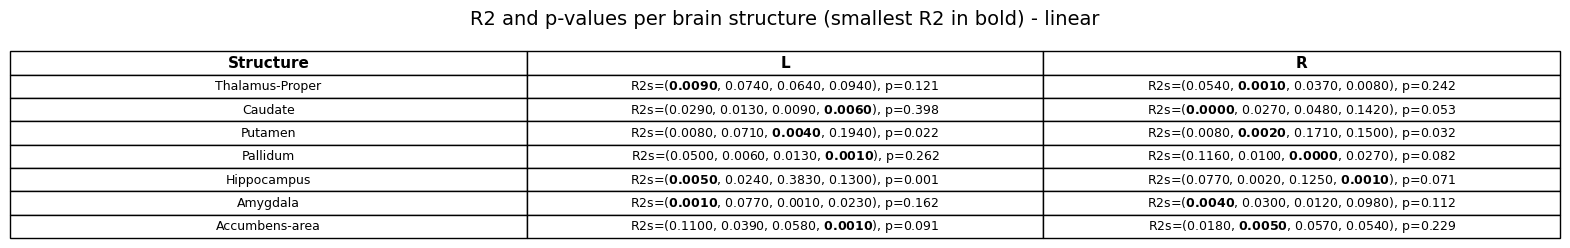

/var/folders/1h/ygmxfx2933lg3n47qtxn__440000gp/T/ipykernel_86792/1862653071.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


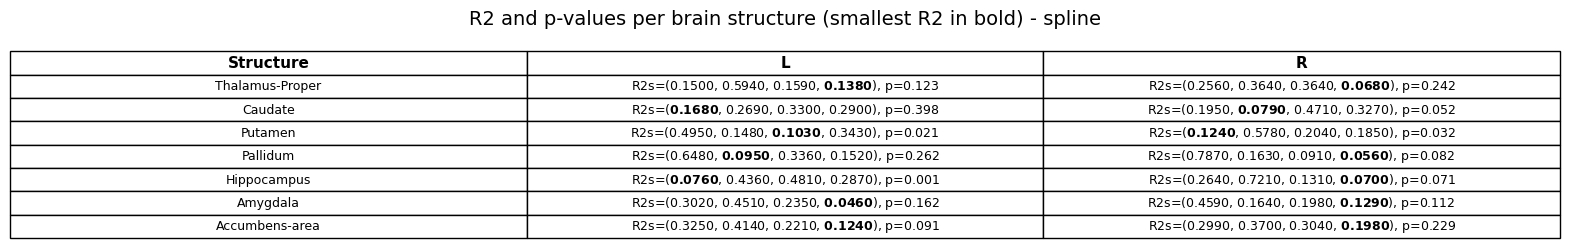

In [52]:
# Helper to parse R2 values and p-value
def parse_r2s_and_p(text):
    match = re.search(r'R2s=\((.*?)\), p=([0-9.]+)', text)
    if match:
        r2s = [float(x.strip()) for x in match.group(1).split(',')]
        pval = float(match.group(2))
        return r2s, pval
    return [], None

for model_type in results:
    # Convert to DataFrame
    model_results_df = pd.DataFrame.from_dict(results[model_type], orient="index")
    model_results_df.index.name = "Structure"
    model_results_df.reset_index(inplace=True)
    
    # Plot the table
    fig, ax = plt.subplots(figsize=(8, len(model_results_df) * 0.2 + 1))
    ax.axis("off")
    
    table = ax.table(
        cellText=model_results_df.values,
        colLabels=model_results_df.columns,
        cellLoc="center",
        loc="center"
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(2.5, 1.4)
    
    # Format each cell with colored smallest R²
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', fontsize=11)
            continue
    
        val = cell.get_text().get_text()
        if col == 1 or col == 2:  # Only "L" and "R" columns
            r2s, p = parse_r2s_and_p(val)
            if r2s:
                min_idx = r2s.index(min(r2s))
                r2s_fmt = []
                for i, v in enumerate(r2s):
                    if i == min_idx:
                        r2s_fmt.append(f"$\\bf{{{v:.4f}}}$")  # math bold
                    else:
                        r2s_fmt.append(f"{v:.4f}")
                new_text = f"R2s=({', '.join(r2s_fmt)}), p={p:.3f}"
                cell.get_text().set_text(new_text)
    
    plt.title(f'R2 and p-values per brain structure (smallest R2 in bold) - {model_type}', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


In [2]:
from statsmodels.stats.multitest import multipletests

# Step 2: Get predictions and residuals
y_pred = model.predict(X)
residuals = y - y_pred
n = len(y)
p = X.shape[1] + 1 # predictors + intercept

# Step 3: Compute standard error of the slope
X_with_intercept = np.hstack([np.ones((n, 1)), X])
MSE = np.sum(residuals**2) / (n - p)
cov_matrix = MSE * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
se_beta = np.sqrt(np.diag(cov_matrix))

# Step 4: Compute t-statistics
coefs = np.concatenate(([model.intercept_], model.coef_))
t_stats = coefs / se_beta

# Step 5: Compute two-sided p-values
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=n - p)) for t in t_stats]

# Step 6: FDR correction
_, q_values, _, _ = multipletests(p_values, method='fdr_bh')

# Print results
for name, coef, t, p, q in zip(['Intercept', 'Slope'], coefs, t_stats, p_values,
q_values):
    print(f"{name}: coef={coef:.3f}, t={t:.3f}, p={p:.4f}, q={q:.4f}")

NameError: name 'model' is not defined